# Предсказание оттока клиентов оператора услуг связи

Необходимо подготовить прототип модели машинного обучения для оператора услуг связи «Ниединогоразрыва.ком».  Модель должна качественно прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Заказчик уточнил свои пожелания - снизить убытки, связанные с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования.

Маркетологи компании выделяют две болевые точки:
1) пользователю предложили промокоды, но он не собирался уходить (False Positive);  
2) пользователю ничего не предложили и он ушёл (False Negative).

Заказчик хочет получить интерпретируемую метрику работы модели, чтобы руководство могло понять отчет - accuracy и матрицу ошибок.

# Описание данных

Заказчик предоставил следующие данные и их описание:
- personal_new.csv - персональные данные клиента
    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга/супруги
    - Dependents - наличие иждивенцев
- contract_new.csv - информация о договоре
    - BeginDate - дата начала пользования услугами
    - EndDate - дата окончания пользования услугами
    - Type - тип договора: ежемесячный, годовой и т.д
    - PaperlessBilling - выставления счёта по электронной почте
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - TotalCharges - всего потрачено денег на услуги
- internet_new.csv - информация об интернет-услугах
    - InternetService - наличие услуг Интернет
    - OnlineSecurity - межсетевой экран
    - OnlineBackup - облачное хранилище файлов для резервного копирования данных
    - DeviceProtection - антивирус
    - TechSupport - выделенная линия технической поддержки
    - StreamingTV - онлайн-ТВ
    - StreamingMovies - онлайн-кинотеатр
- phone_new.csv - информация об услугах телефонии
    - MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно

# План Работ

- Загрузка и ознакомление с данными:
    - загрузка данных
    - проверка данных на пропуски, дубликаты и тип
    - предварительная обработка выявленных аномалий
- Объединение данных:
    - объединение всех таблиц в одну
    - замена типа бинарных категориальных признаков на числовой (Yes/No, Male/Female, Fiber_optic/DSL на 1/0)
    - обработка пропусков
    - выделение целевого признака
    - выделение новых признаков
- Первичный анализ данных:
    - определение дисбаланса классов
    - обзор статистики количественных признаков
    - обзор распределения количественных признаков
    - оценка корреляции признаков
- Предварительные выводы на основе первичного анализа
- Обучение модели и контроль качества:
    - разделение данных на обучающую и тестовую выборки
    - выделение признаков для обучения модели и целевого признака
    - выделение категориальных признаков для кодирования и числовых для масштабирования
    - обучение моделей с подбором гиперпараметров
    - обзор метрики ROC-AUC для обученных моделей
    - выбор лучшей модели
- Проверка лучшей модели на тестовой выборке:
    - расчёт метрики ROC-AUC на тестовой выборке
    - расчёт метрики accuracy на тестовой выборке
    - построение матрицы ошибок для тестовой выборки
    - проверка адекватности модели
- Составление отчёта:
    - ключевые шаги в решении задачи
    - выявленные особенности
    - результат тестирования модели

## Загрузка и ознакомление с данными

In [1]:
# Обновим scikit-learn до поледней версии
!pip install -U scikit-learn

In [2]:
# Импортируем необходимые библиотеки и функции
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (confusion_matrix, roc_auc_score, f1_score,
                             roc_curve, accuracy_score, make_scorer)

# Применим настройки
warnings.filterwarnings("ignore")

# Зададим константы
RANDOM_STATE = 150523
TEST_SIZE = 0.25

In [3]:
# Создадим функцию для открытия файлов
def open_df (file_name):
    try:
        if os.path.exists('/datasets/{}'.format(file_name)):
            return pd.read_csv('/datasets/{}'.format(file_name))
        else:
            return pd.read_csv(
                'https://.../datasets/{}'.format(file_name))
    except:
        print('Не удалось открыть файл "{}!'.format(file_name))

# Создадим функцию вывода основной информацию о датафрейме
def survey_df(df):
    with pd.option_context('display.max_columns', None):
        print('Размер таблицы: {} строк, {} столбцов'.format(
            df.shape[0], df.shape[1]))
        print('Дублирующихся строк:', df.duplicated().sum())
        display(df.sample(25, random_state=RANDOM_STATE))
        df.info()
        
# Создадим функцию преобразования бинарных категориальных признаков
def chg_tpe(x):
    if x == 'Yes' or x == 'Male' or x == 'Fiber optic':
        return 1
    if x == 'No' or x == 'Female' or x== 'DSL':
        return 0
    else: return -1

# Создадим функцию расчёта корреляция Крамера
def cramers_V(var1,var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1
    return (stat/(obs*mini))

In [4]:
# Откроем файлы с данными
personal_df = open_df('personal_new.csv')
contract_df = open_df('contract_new.csv')
internet_df = open_df('internet_new.csv')
phone_df = open_df('phone_new.csv')

In [5]:
# Выведем основную информацию о датафрейме personal_df
survey_df(personal_df)

Размер таблицы: 7043 строк, 5 столбцов
Дублирующихся строк: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
5296,8745-PVESG,Female,0,No,No
2308,3324-OIRTO,Male,0,Yes,Yes
6803,5681-LLOEI,Male,0,Yes,Yes
2716,7883-ROJOC,Female,0,Yes,No
1818,4450-MDZFX,Male,0,Yes,Yes
2043,6557-BZXLQ,Male,1,No,No
6844,6897-UUBNU,Male,0,No,No
4585,1069-XAIEM,Female,1,No,No
897,0678-RLHVP,Female,0,No,No
85,4445-ZJNMU,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Таблица personal_df содержит 7043 записи в 5 столбцах, типы данных соответствуют указанным значениям, пропусков и дубликатов нет.

In [6]:
# Выведем основную информацию о датафрейме contract_df
survey_df(contract_df)

Размер таблицы: 7043 строк, 8 столбцов
Дублирующихся строк: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5296,8745-PVESG,2015-05-01,No,One year,Yes,Credit card (automatic),41.10,2342.7
2308,3324-OIRTO,2014-03-01,No,One year,Yes,Bank transfer (automatic),104.65,8024.56
6803,5681-LLOEI,2016-07-01,No,One year,Yes,Credit card (automatic),91.25,4119.94
2716,7883-ROJOC,2018-07-01,No,Month-to-month,No,Mailed check,44.90,853.1
1818,4450-MDZFX,2015-02-01,No,Month-to-month,No,Bank transfer (automatic),74.35,4594.83
2043,6557-BZXLQ,2018-10-01,No,Month-to-month,No,Electronic check,69.65,1125.54
6844,6897-UUBNU,2017-09-01,2018-03-01,Month-to-month,No,Mailed check,89.65,537.9
4585,1069-XAIEM,2019-11-01,No,Month-to-month,Yes,Electronic check,85.05,267.91
897,0678-RLHVP,2015-09-01,No,Two year,No,Electronic check,105.55,5929.8
85,4445-ZJNMU,2019-05-01,No,Month-to-month,Yes,Credit card (automatic),99.30,893.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Таблица contract_df содержит 7043 записи в 5 столбцах. Количество контрактов соответствует количеству клиентов. Пропусков и дубликатов нет. Тип данных в поле TotalCharges не соответствуют указанным значениям, похоже среди записей есть текстовые элементы. Преобразуем поле TotalCharges к типу float с заменой ошибочных записей на пропуск (NaN). Поля с датами обработаем и преобразуем после объединения таблиц.

In [7]:
# Произведём преобразование
contract_df['TotalCharges'] = pd.to_numeric(
    contract_df['TotalCharges'], errors='coerce')

# И проверим результат
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Теперь тип данных в поле TotalCharges соответствует указанным значениям, но появилось 11 пропусков. Пока оставим их, решим что с ними делать после объединения данных.

In [8]:
# Выведем основную информацию о датафрейме internet_df
survey_df(internet_df)

Размер таблицы: 5517 строк, 8 столбцов
Дублирующихся строк: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3288,0017-IUDMW,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4003,4128-ETESU,Fiber optic,No,No,Yes,No,Yes,Yes
4086,4299-SIMNS,Fiber optic,Yes,No,No,No,No,No
3835,8565-WUXZU,Fiber optic,Yes,Yes,No,Yes,No,No
4508,9761-XUJWD,DSL,No,Yes,No,Yes,No,Yes
3787,8714-EUHJO,Fiber optic,No,Yes,No,No,No,Yes
4161,9866-OCCKE,Fiber optic,Yes,No,Yes,Yes,Yes,Yes
1751,3298-QEICA,DSL,Yes,No,No,Yes,No,No
1134,7077-XJMET,DSL,No,No,Yes,Yes,Yes,Yes
968,1373-ORVIZ,DSL,No,No,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Таблица internet_df содержит 5517 записей в 8 столбцах. Похоже не все клиенты пользуются интернетом. Типы данных соответствуют указанным значениям, пропусков и дубликатов нет.

In [9]:
# Выведем основную информацию о датафрейме phone_df
survey_df(phone_df)

Размер таблицы: 6361 строк, 2 столбцов
Дублирующихся строк: 0


,customerID,MultipleLines
224,4629-NRXKX,No
1572,5935-FCCNB,Yes
1165,6260-ONULR,No
3956,9133-AYJZG,Yes
2515,0197-PNKNK,Yes
1753,7696-CFTAT,No
975,4194-WHFCB,Yes
4896,0292-WEGCH,Yes
3240,5998-VVEJY,Yes
6047,0064-SUDOG,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Таблица phone_df содержит 6361 запись в 2 столбцах. И телефоном пользуются не все. Типы данных соответствуют указанным значениям, пропусков и дубликатов нет.

## Объединение данных

In [10]:
# Проверим уникальность значений в поле customerID для всех таблиц
print(personal_df['customerID'].value_counts().max(), ', ',
      contract_df['customerID'].value_counts().max(), ', ',
      internet_df['customerID'].value_counts().max(), ', ', 
      phone_df['customerID'].value_counts().max())

1 ,  1 ,  1 ,  1


Все таблицы содержат поле customerID. Каждый пользователь в каждой таблице встречается только 1 раз. Можно переходить к объёдинению таблиц по полю customerID.

In [11]:
# Объединим таблицы
full_df = personal_df.merge(
    contract_df, on='customerID', how='left').merge(
    internet_df, on='customerID', how='left').merge(
    phone_df, on='customerID', how='left')

# И проверим результат
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Итоговая таблица содержит все записи из предоставленных таблиц. Пропуски есть только в полях из присоединённых таблиц internet_df и phone_df, количество записей в них соответсвует исходным. Объединение таблиц прошло корректно.

Столбцы gender, Partner, Dependents, PaperlessBilling, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines являются бинарными категориальными, столбцы из присоединённых таблиц содержат пропуски. Заменим значения в них на 1/0 (Yes/No, Male/Female, Fiber_optic/DSL на 1/0), а пропуски "заглушкой" - "-1", т.е. услуга не предоставлена.

In [12]:
# Создадим список бинарных категориальных признаков
bin_feat = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 
            'StreamingMovies', 'MultipleLines']
# И для верности проверим, что они бинарные
for i in range(len(bin_feat)):
    print(full_df[bin_feat[i]].unique())

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['DSL' 'Fiber optic' nan]
['No' 'Yes' nan]
['Yes' 'No' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
[nan 'No' 'Yes']


Все выбранные поля содежат бинарные значения, в некоторых встречаются пропуски. Перейдём к обработке.

In [13]:
# Применим преобразование
for i in range(len(bin_feat)):
    full_df[bin_feat[i]] = full_df[bin_feat[i]].apply(lambda x: chg_tpe(x))

Добавим столбец client_left с целевым признаком. Поле EndDate содержит дату окончания пользования услугами либо значение 'No', т.е пользователь продолжает пользоваться услугами. Воспользуемся этим.

In [14]:
full_df.loc[full_df['EndDate'] == 'No', 'client_left'] = 0
full_df['client_left'] = full_df['client_left'].fillna(1)
full_df['client_left'] = full_df['client_left'].astype('int')

При обучении модели мы не будем использовать информацию из столбцов BeginDate и EndDate, поскольку это ограничит модель, плюс поле EndDate приведёт к утечке целевого признака. Вместо непосредственно дат мы можем посчитать как долго клиенты обслуживались оператором связи. Так утечки не произойдёт и не будет рамок для прогнозирования, а так же даст нам дополнительную информацию о поведении клиентов, позволит посмотреть на корреляцию с другими признаками. Нам известно что информация о договорах актуальна на 1 февраля 2020 г. Т.е. значение 'No' в поле EndDate можно заменить на дату актуальности информации и вычислить как долго клиент обслуживался.

In [15]:
# Заменим No на дату актуальности информации
full_df['EndDate'] = full_df['EndDate'].replace('No','2020-02-01')
# Приведём столбец BeginDate к правильному типу
full_df['BeginDate'] = pd.to_datetime(full_df['BeginDate'], format='%Y-%m-%d')
# Приведём столбец EndDate к правильному типу
full_df['EndDate'] = pd.to_datetime(full_df['EndDate'], format='%Y-%m-%d')
# Посчитаем дни
full_df['days_serviced'] = (full_df['EndDate'] - full_df['BeginDate']).dt.days

In [16]:
# Заполним недостающие значения в поле TotalCharges
full_df.loc[full_df['TotalCharges'].isna(), 'TotalCharges'] = round(
    (full_df.loc[full_df['TotalCharges'].isna(), 'EndDate'] - 
     full_df.loc[full_df['TotalCharges'].isna(), 'BeginDate']) / 
    np.timedelta64 ( 1 , 'M') * 
    full_df.loc[full_df['TotalCharges'].isna(), 'MonthlyCharges'], 2)

In [17]:
# Проверим результат
survey_df(full_df)

Размер таблицы: 7043 строк, 22 столбцов
Дублирующихся строк: 0


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_left,days_serviced
5296,8745-PVESG,0,0,0,0,2015-05-01,2020-02-01,One year,1,Credit card (automatic),41.10,2342.70,0,1,0,1,1,0,0,-1,0,1737
2308,3324-OIRTO,1,0,1,1,2014-03-01,2020-02-01,One year,1,Bank transfer (automatic),104.65,8024.56,1,1,1,1,0,1,1,0,0,2163
6803,5681-LLOEI,1,0,1,1,2016-07-01,2020-02-01,One year,1,Credit card (automatic),91.25,4119.94,1,1,0,1,1,0,0,1,0,1310
2716,7883-ROJOC,0,0,1,0,2018-07-01,2020-02-01,Month-to-month,0,Mailed check,44.90,853.10,0,0,0,0,0,0,0,0,0,580
1818,4450-MDZFX,1,0,1,1,2015-02-01,2020-02-01,Month-to-month,0,Bank transfer (automatic),74.35,4594.83,1,0,0,0,0,0,0,1,0,1826
2043,6557-BZXLQ,1,1,0,0,2018-10-01,2020-02-01,Month-to-month,0,Electronic check,69.65,1125.54,1,0,0,0,0,0,0,0,0,488
6844,6897-UUBNU,1,0,0,0,2017-09-01,2018-03-01,Month-to-month,0,Mailed check,89.65,537.90,1,0,1,0,1,1,0,0,1,181
4585,1069-XAIEM,0,1,0,0,2019-11-01,2020-02-01,Month-to-month,1,Electronic check,85.05,267.91,1,0,0,0,0,0,1,1,0,92
897,0678-RLHVP,0,0,0,0,2015-09-01,2020-02-01,Two year,0,Electronic check,105.55,5929.80,1,0,1,1,0,1,1,1,0,1614
85,4445-ZJNMU,1,0,0,0,2019-05-01,2020-02-01,Month-to-month,1,Credit card (automatic),99.30,893.70,1,0,1,0,0,1,1,1,0,276


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   int64         
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   int64         
 4   Dependents        7043 non-null   int64         
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   int64         
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  InternetService   7043 non-null   int64         
 13  OnlineSecurity    7043 non-null   int64         
 14  OnlineBackup      7043 n

Данные загружены, объединены и предобработаны: типы данных приведены в соответствие значениям, бинарные категориальные значения приведены к числовым (0/1), пропуски в категориальных бинарных признаках заполнены заглушкой (-1), заполнены пропуски в количественном признаке, выделен целевой признак, посчитаны дни обслуживания.

Перейдём к первичному анализу.

## Первичный анализ данных

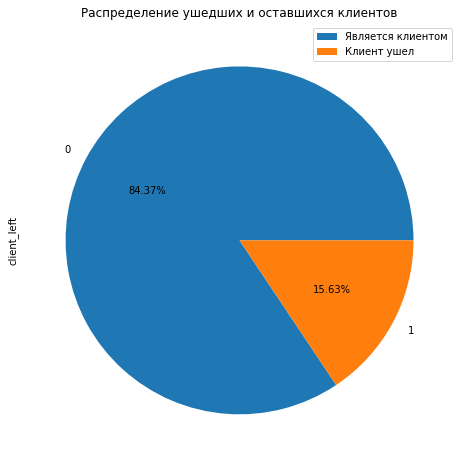

In [18]:
# Посмотрим на соотношение ушедших и оставшихся клиентов
full_df['client_left'].value_counts().plot(
    kind = 'pie', figsize = (8,8), autopct='%1.2f%%')
plt.title('Распределение ушедших и оставшихся клиентов')
plt.legend(['Является клиентом', 'Клиент ушел'])
plt.title('Распределение ушедших и оставшихся клиентов');

В имеющейся выборке мы видим, что от услуг связи отказались 15,63% клиентов. Будем это учитывать при разбиении выборки на обучающую и тестовую.

In [19]:
# Посмотрим на статистики полученной таблицы
full_df.describe()

,gender,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_left,days_serviced
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,0.592219,64.761692,2115.312885,0.222916,0.069999,0.128212,0.127219,0.073548,0.167684,0.171234,0.325004,0.156325,898.555729
std,0.500013,0.368612,0.499748,0.458110,0.491457,30.090047,2112.742814,0.778877,0.706051,0.738369,0.737868,0.708201,0.756958,0.758507,0.642730,0.363189,683.130510
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,436.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,276.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1343.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,761.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,89.850000,3236.690000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1461.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,9221.380000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2314.000000


В статистиках не наблюдаем каких либо отклонений и аномалий.

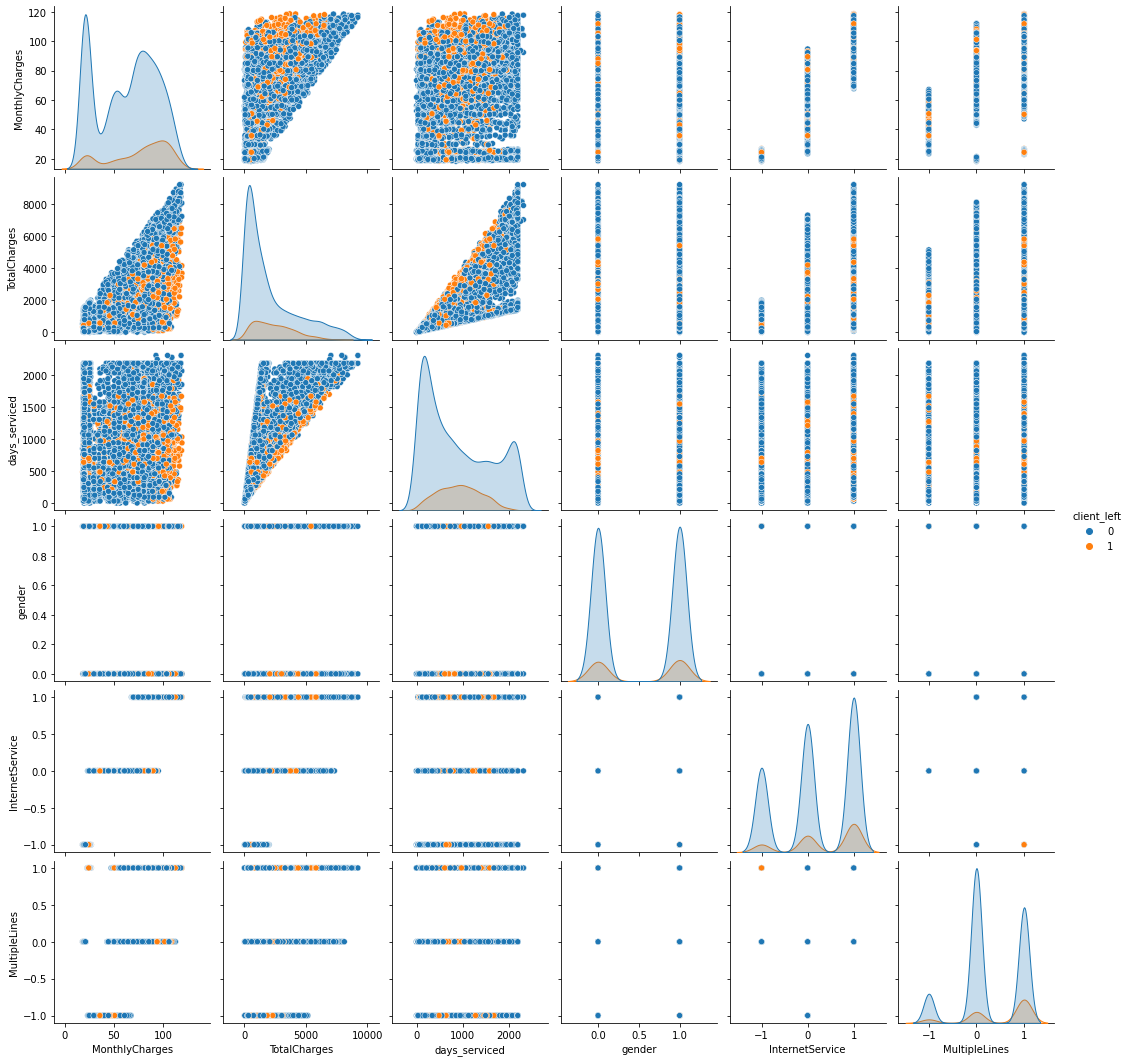

In [20]:
# Посмотрим на распределение количественных признаков с 
# некоторыми бинарными с выделением остался/ушел клиент
sns.pairplot(full_df[['MonthlyCharges', 'TotalCharges', 'days_serviced', 
                      'gender', 'InternetService', 'MultipleLines', 
                      'client_left']], hue='client_left');

На графиках распределения количественных признаков видим:
- ежемесячные траты на услуги ушедших и оставшихся клиентов имеют по два основнх всплеска - первый с большим количеством небольших трат, и второй с ещё бОльшим количеством клиентов с большими тратами для ушедших, и меньшим количеством с большими тратами для оставшихся клиентов 
- общие траты для ушедших и оставшихся так же примерно похожи - значительное число клиентов с меньшими тратами, с увеличением трат количество клиетов уменьшается
- график срока обслуживания для ушедших клиетов достаточно равномерный, а вот для оставшихся видим два всплеска - похоже за последнее время было много новых пользователей, которые потом так же быстро уходили, плюс имеем значительное количество лояльных клиентов
- хорошо видна зависимость общих трат от длительности ослуживания и ежемесячных трат, с хорошо различимыми группами ушедших и оставшихся клиентов
- на графике зависимости месячных трат от длительности обслуживания хорошо различимо, что ушедшие клиенты имели высокие ежемесячные траты.

Дополнительно можно выделить:
- доли ушедших и оставшихся мужчин и женщин примерно оди наковые
- можно выделить группу ушедших женщин, обслуживавшихся примерно от 1,5 до 2,5 лет и имели высокие ежемесячные траты
- количество тех, кто не пользовался интернет сервисами заментно меньше чем тех кто пользовался, в обоих категориях (ушел/остался) примерно в одинаковых пропорциях, наиболее популярна услуга подключения Fiber optic
- в телефонии ситуация немного другая: тех кто не пользовался значительно меньше тех кто пользовался, возможность подключения телефонного аппарата к нескольким линиям одновременно менее популярна, но в ней заметно больше ушедших клиентов.

In [21]:
# Посмотрим подробнее на статистику длительности 
# обслуживания для ушедших и оставшихся клиентов
pd.DataFrame(full_df.groupby('client_left')[
    'days_serviced'].agg(['min', 'max', 'median', 'mean']))

,min,max,median,mean
client_left,,,,
0,0,2314,702,893.681084
1,28,2129,915,924.863760


Значения минимальной, максимальной и средней длительности обслуживания близки, хорошо заметна разница для медианного значения, у оставшихся оно заметно меньше. Ещё одно подтверждение что был наплыв клиентов примерно 2 года назад.

In [22]:
# Проверим, что за одинокая точка с указанием на уход клиена на 
# пересечении отсутствия подключения к интернету и наличия возможность 
# подключения телефонного аппарата к нескольким линиям одновременно
pd.DataFrame(full_df.query('MultipleLines == 1 & InternetService == -1'
                          )['client_left'].value_counts())

,client_left
0,276
1,66


Похоже, ушли не все у кого нет подключения к интернет и есть несколько телефонных линий.

In [23]:
# Посмотрим на соотношение ушедших и оставшихся клиентов в разрезе типа договора
pd.DataFrame(full_df.groupby('Type')[
    'client_left'].agg('value_counts', 'mean').round(4)*100)

client_left
Type           client_left             
Month-to-month 0                  89.50
               1                  10.50
One year       0                  78.75
               1                  21.25
Two year       0                  77.52
               1                  22.48

Видим, что клиенты с типом договора Month-to-month уходили в два раза реже (10.5%) чем клиенты с типом договора One year (21.26%) и Two year (22.61%).

In [24]:
# Посмотрим на соотношение ушедших и оставшихсяклиентов в разрезе способа оплаты
pd.DataFrame(full_df.groupby('PaymentMethod')[
    'client_left'].agg('value_counts', 'mean').round(4)*100)

client_left
PaymentMethod             client_left             
Bank transfer (automatic) 0                  79.47
                          1                  20.53
Credit card (automatic)   0                  79.17
                          1                  20.83
Electronic check          0                  85.20
                          1                  14.80
Mailed check              0                  92.74
                          1                   7.26

Тут видим, что чаще уходили клиенты с автоматическим способом оплаты, для Bank transfer (automatic) - 20.56%, для Credit card (automatic) - 20.84%. Немного реже уходили клиенты со способами оплаты Electronic check - 14.8%. Наиболее лояльные клиенты используют метод Mailed check - 7.29% ушедших.

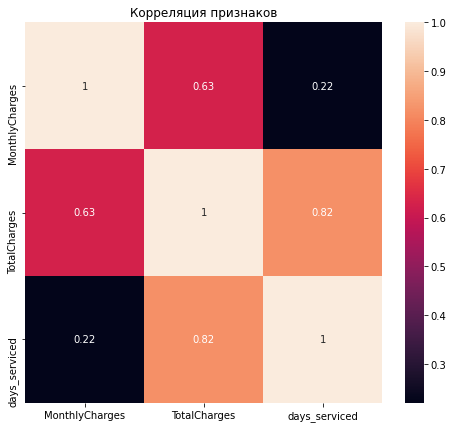

In [25]:
# Посмотрим на корреляцию количественных признаков
plt.figure(figsize=(8, 7))
sns.heatmap(full_df[['MonthlyCharges', 
                     'TotalCharges', 
                     'days_serviced']].corr(), annot=True)
plt.title('Корреляция признаков');

На графике видим сильную корреляцию между ежемесячными тратами и общими тратами, а так же очень сильную - между общими тратами и длительностью обслуживания, что не удивительно: общие траты складываются из ежемесячных, и чем дольше обслуживаешся - тем больше потрачено. Учтём это при построении линейных моделей.

Посмотрим на корреляцию категориальных признаков.

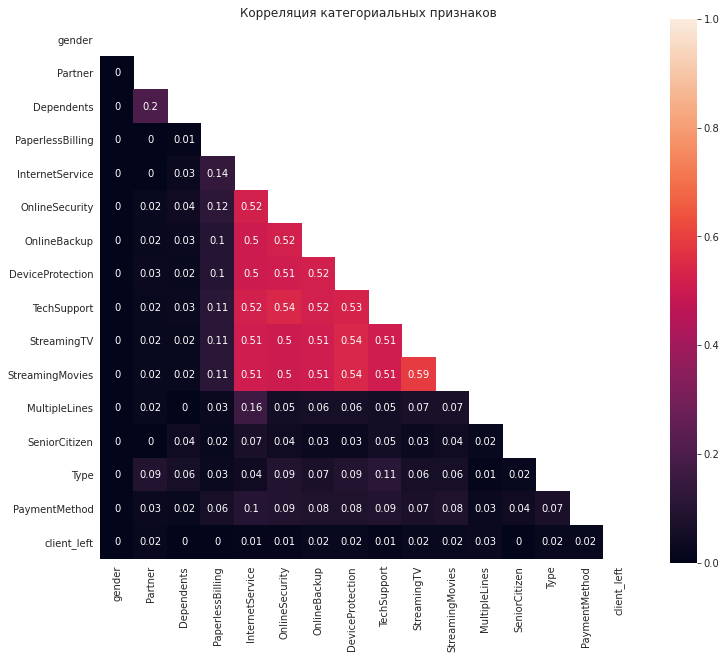

In [26]:
# Добавим недостающие поизнаки к списку категориальных
cat_feat = bin_feat + ['SeniorCitizen', 'Type', 'PaymentMethod', 'client_left']

# произведём кодирование категориальных признаков
label = LabelEncoder()
data_encoded = pd.DataFrame()
for i in cat_feat:
    data_encoded[i]=label.fit_transform(full_df[i])

# посчитаем корреляцию Крамера для категориальных признаков
rows= []
for var1 in data_encoded:
    col = []
    for var2 in data_encoded:
        cramers = cramers_V(data_encoded[var1], data_encoded[var2])
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns=data_encoded.columns, 
                  index=data_encoded.columns)

# Построим график Корреляции Крамера для категориалных признаков
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 10))
with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask, vmin=0., vmax=1, square=True, annot=True)
plt.title('Корреляция категориальных признаков')
plt.show();

На графике хорошо видна сильная корреляция информации об интернет-услугах, т.е. при использовании услуги подключения к интернет - клиенты часто выбирают дополнительные услуги, особенно сильна эта взаимосвязь для StreamingTV. Возможно какие то из этих услуг доступны "по умочанию", или стали причиной подключения к интернету. Учтём это при построении линейных моделей. Сильных связей с целевым признаком - нет.

## Предварительные выводы на основе первичного анализа

В результате превичного анализа было выявлено следующее:
- определён дисбаланс классов: выборка содержит 84.34% пользующихся услугами связи и 15,66% ушедших клиентов
- данные не содержат выбросов и анамалий
- клиенты с бОльшими ежемесячными тратами уходили чаще
- соотношение мужчин и женщин в выборке примерно равны, с примерно равными долями ушедших и оставшихся
- чаще уходили клиенты с типом договора One year и Two year, и автоматическим способом оплаты Bank transfer (automatic) и Credit card (automatic)
- обнаружены корреляции между типом подключения к интернет и дополнительными интернет-сервисами, между тратами на обслуживание и длительностью обслуживания. 

## Обучение модели и контроль качества

Подготовим данные, основываясь на первичном анализе и уточнениях тимлида:
- отбросим поля customerID, BeginDate и EndDate
- отбросим поле TotalCharges - всего потрачено денег на услуги, эту информацию можно получить, зная MonthlyCharges - ежемесячные траты на услуги, и days_serviced - длительность обслуживания. К тому же для новых клиентов TotalCharges будет мало значимым для оценки поведения
- корреляции между категориальными признаками заметно ниже чем между количественными, пока оставим их все.

In [27]:
# Удалим целевой признак из спаска категориальных признаков
cat_feat.remove('client_left')
# Вернём категориальным признакам тип object
full_df[cat_feat] = full_df[cat_feat].astype('object')

# Разделим выборку на тренировочную и тестовую, 
# отделив целевой признак, и отбросив лишние.
# Учтём дисбаланс классов и добавим перемешивание.
features_train, features_test, target_train, target_test = \
    train_test_split(full_df.drop(columns=['client_left', 'customerID', 
                                           'BeginDate', 'EndDate', 
                                           'TotalCharges']), 
                     full_df['client_left'], 
                     test_size=TEST_SIZE, 
                     random_state=RANDOM_STATE, 
                     stratify=full_df['client_left'], shuffle=True)

# И проверим корректность разделения
print(' Размер тренировочной выборки:', features_train.shape, '\n', 
      'Размер тестовой выборки:     ', features_test.shape, '\n')
print(' Доля ушедших клиентов в тренировочной выборке:', 
      f'{target_train.mean():.2%}', '\n', 
     'Доля ушедших клиентов в тестовой выборке:     ', 
      f'{target_test.mean():.2%}')

 Размер тренировочной выборки: (5282, 17) 
 Размер тестовой выборки:      (1761, 17) 

 Доля ушедших клиентов в тренировочной выборке: 15.64% 
 Доля ушедших клиентов в тестовой выборке:      15.62%


Данные разделены корректно: соотношение выборок 3:1 (тренировочная : тестовая), процент ушедших клиентов в выборках соответствует исходному - 15.63%

Перейдём к обучению моделей.

In [28]:
# Создадим преобразователь категориальных и количественных признаков
col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),
     cat_feat),
    (StandardScaler(), ['MonthlyCharges', 'days_serviced']),
    remainder='passthrough', verbose_feature_names_out=False)

# Создадим оценщик
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [29]:
# Создадим пайплайн для модели LogisticRegression с преобразовангием признаков
pipeline_lr = Pipeline([("trnsf", col_transformer), 
                        ("clf", LogisticRegression(random_state=RANDOM_STATE, 
                                                   n_jobs=-1))])
# Создадим список гиперпараметров для поиска
param_grid = {'clf__penalty' : ['l1', 'l2'],
              'clf__C': np.arange(0.1, 0.5, 0.1),
              'clf__max_iter': [50, 100, 150], 
              'clf__class_weight' : ['balanced', None], 
              'clf__solver' : ['lbfgs', 'liblinear']}
# Обучим и найдём лучшие гиперпараметры для LogisticRegression
grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid, 
                       scoring = roc_auc_scorer, cv=5, n_jobs=-1)
grid_lr.fit(features_train, target_train)
# Проверим результат
print('Best parameters is:', grid_lr.best_params_)

Best parameters is: {'clf__C': 0.2, 'clf__class_weight': None, 'clf__max_iter': 50, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [30]:
# Создадим пайплайн для модели RandomForestClassifier с преобразовангием признаков
pipeline_rf = Pipeline([("trnsf", col_transformer), 
                        ("clf", RandomForestClassifier(random_state=RANDOM_STATE, 
                                                   n_jobs=-1))])
# Создадим список гиперпараметров для поиска
param_grid = {'clf__max_depth': [10, None], 
              'clf__n_estimators': range(300, 501, 100), 
              'clf__min_samples_split': [3, 4, 5],
              'clf__min_samples_leaf': [1, 2, 3],
              'clf__criterion' : ['gini', 'entropy', 'log_loss']}
# Обучим и найдём лучшие гиперпараметры для RandomForestClassifier
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_grid, 
                       scoring = roc_auc_scorer, cv=5, n_jobs=-1)
grid_rf.fit(features_train, target_train)
# Проверим результат
print('Best parameters is:', grid_rf.best_params_)

Best parameters is: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 400}


In [31]:
# CatBoostClassifier умеет работать с категориальными признаками
# и не требует масштабирования, перейдём сразу к поиску гиперпараметров.
# Создадим список гиперпараметров для поиска
param_grid = {'depth': [2, 6, 10, 15],
              'iterations': range(300, 1200, 100),
              'learning_rate': np.arange(0.3, 0.8, 0.1),
              'l2_leaf_reg': range(1, 6), 
              'loss_function' : ['Logloss', None]}
# Обучим и найдём лучшие гиперпараметры для CatBoostClassifier
grid_cb = GridSearchCV(CatBoostClassifier(cat_features=cat_feat, 
                                          random_seed=RANDOM_STATE, silent=True),
                       scoring=roc_auc_scorer, param_grid=param_grid, cv=5, n_jobs=-1)
grid_cb.fit(features_train, target_train)
# Проверим результат
print('Best parameters is:', grid_cb.best_params_)

Best parameters is: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 2, 'learning_rate': 0.3, 'loss_function': 'Logloss'}


In [32]:
# Сведём в таблицу значения метрики ROC-AUC для моделей,
# а так же время их обучения и предсказания
grid_res_lr = pd.DataFrame(grid_lr.cv_results_).sort_values(
    by='rank_test_score').reset_index(drop=True)
grid_res_rf = pd.DataFrame(grid_rf.cv_results_).sort_values(
    by='rank_test_score').reset_index(drop=True)
grid_res_cb = pd.DataFrame(grid_cb.cv_results_).sort_values(
    by='rank_test_score').reset_index(drop=True)
pd.DataFrame({'Качество предсказания (ROC-AUC)' : 
              [round(grid_lr.best_score_, 3),
               round(grid_rf.best_score_, 3),
               round(grid_cb.best_score_, 3)], 
              'Время обучения, сек.' : 
              [round(grid_res_lr.loc[0]['mean_fit_time'], 2), 
               round(grid_res_rf.loc[0]['mean_fit_time'], 2), 
               round(grid_res_cb.loc[0]['mean_fit_time'], 2)], 
              'Время предсказания, сек.' : 
              [round(grid_res_lr.loc[0]['mean_score_time'], 2), 
               round(grid_res_rf.loc[0]['mean_score_time'], 2), 
               round(grid_res_cb.loc[0]['mean_score_time'], 2)]}, 
             index=['LogisticRegression', 'RandomForestClassifier', 
                    'CatBoostClassifier']).sort_values(
    by='Качество предсказания (ROC-AUC)', ascending=False)

,Качество предсказания (ROC-AUC),"Время обучения, сек.","Время предсказания, сек."
CatBoostClassifier,0.900,15.37,0.01
RandomForestClassifier,0.817,1.55,0.12
LogisticRegression,0.749,1.02,0.11


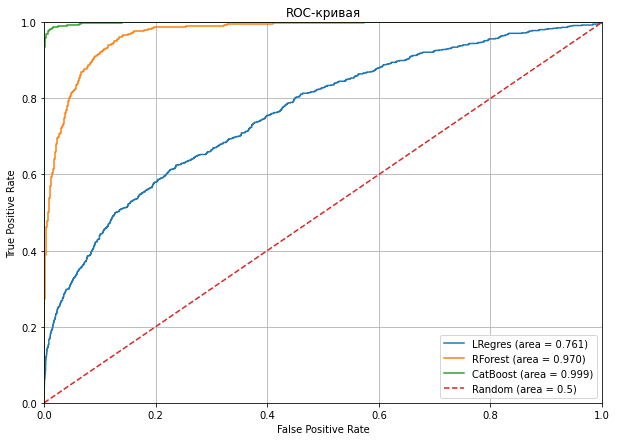

In [33]:
# Посмотрим на ROC-кривые обученных моделей для тренировочной выборки
# Подготовим значения TPR, FPR и AUC-ROC для модели LogisticRegression
probabilities_valid = grid_lr.predict_proba(features_train)
fpr_lr, tpr_lr, thresholds = roc_curve(target_train, probabilities_valid[:, 1])
auc_roc_lr = roc_auc_score(target_train, probabilities_valid[:, 1])

# Подготовим значения TPR, FPR и AUC-ROC для модели RandomForestClassifier
probabilities_valid = grid_rf.predict_proba(features_train)
fpr_rf, tpr_rf, thresholds = roc_curve(target_train, probabilities_valid[:, 1])
auc_roc_rf = roc_auc_score(target_train, probabilities_valid[:, 1])

# Подготовим значения TPR, FPR и AUC-ROC для модели CatBoostClassifier
probabilities_valid = grid_cb.predict_proba(features_train)
fpr_cb, tpr_cb, thresholds = roc_curve(target_train, probabilities_valid[:, 1])
auc_roc_cb = roc_auc_score(target_train, probabilities_valid[:, 1])

# Построим ROC-кривые
plt.figure(figsize = (10, 7))
plt.plot(fpr_lr, tpr_lr, label='LRegres (area = {0:0.3f})'.format(auc_roc_lr))
plt.plot(fpr_rf, tpr_rf, label='RForest (area = {0:0.3f})'.format(auc_roc_rf))
plt.plot(fpr_cb, tpr_cb, label='CatBoost (area = {0:0.3f})'.format(auc_roc_cb))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show();

Видим отличия значений ROC-AUC по результатам обучения моделей и на графике - это связно с тем, что метрика при обучении вычислялась для валидационной выборки, а графики построены для всей тренировочной выборки. Но это не отменяет того, что явным лидером является модель CatBoostClassifier.

Изучим важность признаков для лучшей модели.

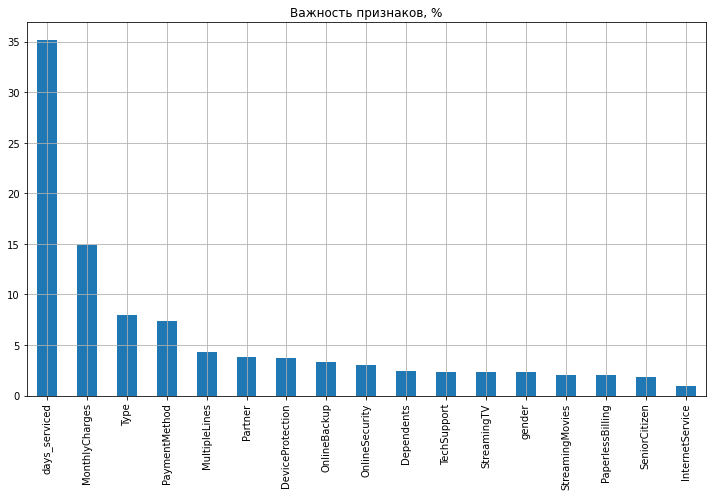

In [34]:
# Посмотрим на выжность признаков модели CatBoostClassifier
# с найденными значениями гиперпараметров
fig, ax = plt.subplots(figsize=(10,7))
pd.Series(CatBoostClassifier(cat_features=cat_feat, 
                             random_seed=RANDOM_STATE, 
                             silent=True, depth=6, 
                             iterations=1000, 
                             learning_rate=0.3, 
                             l2_leaf_reg=2, 
                             loss_function='Logloss').\
          fit(features_train, target_train).get_feature_importance(), 
          features_train.columns).sort_values(ascending=False).\
    plot.bar(ax=ax, grid=True)
ax.set_title("Важность признаков, %")
fig.tight_layout()

По результатм обучения и проверки моделей можно сделать выводы:
- лучшей моделью в нашей задаче является CatBoostClassifier, значение метрики ROC-AUC = 0.9
- найдены лучшие значения гиперпараметров для модели: 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 2, 'learning_rate': 0.3, 'loss_function': 'Logloss'
- модель обучалась значительно дольше конкурентов, но имеет хорошее время предсказания
- самый незначительный признак для модели InternetService (наличие услуг Интернет) - важность менее 1%, наиболее значимые: days_serviced (длительность обслуживания) - важность более 35%, MonthlyCharges (ежемесячные траты на услуги) - важность примерно 15%, Type (тип договора) и PaymentMethod (способ оплаты) - порядка 7..8%. Важность оставшихся признаков менее 5%.

## Проверка лучшей модели на тестовой выборке

Лучшая модель выбрана. Посмотрим её метрики качества на тестовой выборке. 

In [35]:
# Посмотрим значение метрики ROC-AUC лучшей моели для тестовой выборки
round(roc_auc_score(target_test, grid_cb.predict_proba(features_test)[:, 1]), 3)

0.924

In [36]:
# Посмотрим значение метрики f1 лучшей моели для тестовой выборки
round(f1_score(target_test, grid_cb.predict(features_test)), 3)

0.688

In [37]:
# Посмотрим значение метрики accuracy лучшей моели для тестовой выборки
round(accuracy_score(target_test, grid_cb.predict(features_test)), 3)

0.915

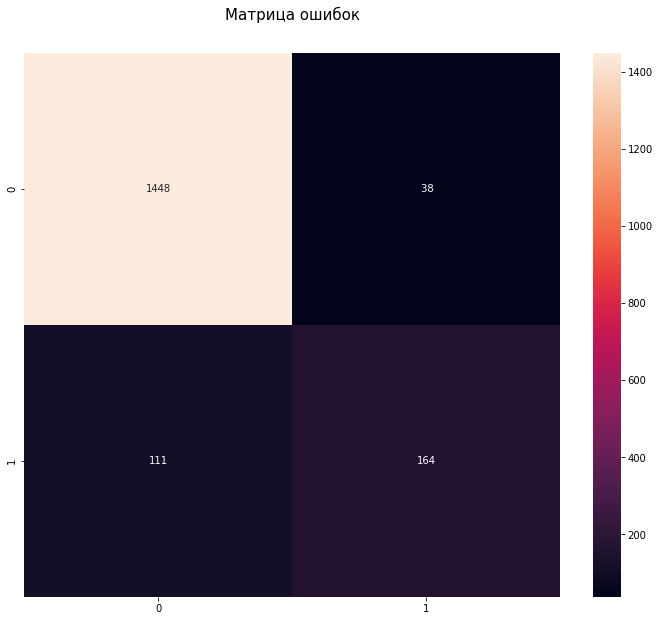

In [38]:
# Построим матрицу ошибок лучшей моели для тестовой выборки
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(
    target_test, grid_cb.predict(features_test)),annot=True, fmt='3.0f')
plt.title('Матрица ошибок', y=1.05, size=15);

Хороший результат, модель чаще предсказывает ложно-негативные случаи (т.е. пользователю ничего не предложили и он ушёл) - 111, чем ложно-позитивные (пользователю предложили промокоды, но он не собирался уходить) - 38, т.е. необоснованных трат будет меньше. Плюс модель хорошо научилась определять уход клиента: ROC-AUC = 0.924, accuracy = 0.915.

Теперь проверим модель на адекватность: создадим константную модель и сравним метрики качества с CatBoostClassifier. 

In [39]:
# Создадим и обучим константную модель DummyClassifier
model_dm = DummyClassifier(strategy='stratified', 
                           random_state=RANDOM_STATE)
model_dm.fit(features_train,target_train);

In [40]:
# Посмотрим значение метрики ROC-AUC модели DummyClassifier для тестовой выборки
round(roc_auc_score(target_test, 
                    model_dm.predict_proba(features_test)[:, 1]), 3)

0.478

In [41]:
# Посмотрим значение метрики f1 модели DummyClassifier для тестовой выборки
round(f1_score(target_test, model_dm.predict(features_test)), 3)

0.122

In [42]:
# Посмотрим значение метрики accuracy модели DummyClassifier для тестовой выборки
round(accuracy_score(target_test, model_dm.predict(features_test)), 3)

0.722

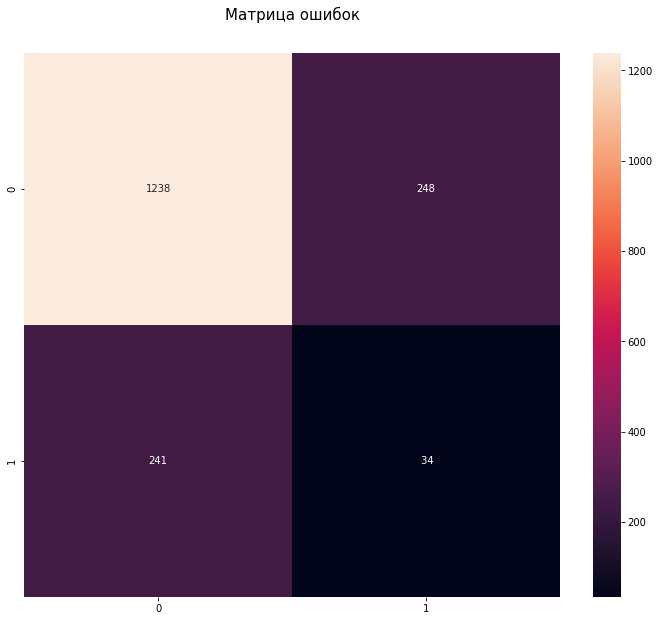

In [43]:
# Построим матрицу ошибок модели DummyClassifier для тестовой выборки
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(
    target_test, model_dm.predict(features_test)),annot=True, fmt='3.0f')
plt.title('Матрица ошибок', y=1.05, size=15);

Результат константной модели ожидаемо хуже, с ней у компани точно будут значительные необоснованные траты и потеря клиентов.

Посмотрим на ROC-кривые моделей CatBoostClassifier и DummyClassifier для тестовой выборки.

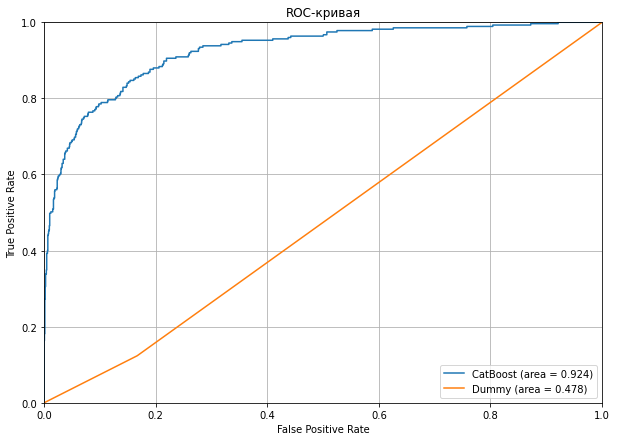

In [44]:
# Подготовим значения TPR, FPR и AUC-ROC для модели DummyClassifier
probabilities_valid = model_dm.predict_proba(features_test)
fpr_dm, tpr_dm, thresholds = roc_curve(target_test, probabilities_valid[:, 1])
auc_roc_dm = roc_auc_score(target_test, probabilities_valid[:, 1])
# Подготовим значения TPR, FPR и AUC-ROC для модели CatBoostClassifier
probabilities_valid = grid_cb.predict_proba(features_test)
fpr_cb, tpr_cb, thresholds = roc_curve(target_test, probabilities_valid[:, 1])
auc_roc_cb = roc_auc_score(target_test, probabilities_valid[:, 1])

# Построим ROC-кривые
plt.figure(figsize = (10, 7))
plt.plot(fpr_cb, tpr_cb, label='CatBoost (area = {0:0.3f})'.format(auc_roc_cb))
plt.plot(fpr_dm, tpr_dm, label='Dummy (area = {0:0.3f})'.format(auc_roc_dm))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show();

Адеквтность модели CatBoostClassifier не вызывает сомнений, показывает хорошие метрики качества, хорошо обрабатывает "болевые точки".

## Составление отчёта

**В процессе решения задачи были выполнены все запланированные шаги:**
- данные корректно загружены, произведено ознакомление
- все данные сведены в одну таблицу, обработаны пропуски и категориальные признаки, выделен целевой признак, сгенерирован дополнителный признак
- произведён анализ данных: выявлен дисбаланс класоов, представлен обзор статистики и распределения количественных признаков, выявлены корреляции в колисественных и категориальных признаках, дополнительно изучена доля ушедших клиентов в зависимости от типа договора и способа оплаты
- сделаны предварительные выводы
- были обучены модели: данные разделены на обучающую и тестовую выборки, тренировочный набор передан для обучения моделей, произведён контроль качества обученных моделей, выбрана лучшая модель, изучена важность признаков для лучшей модели
- лучшая модель была проверена на тестовой выборке: вычислены значения контрольных метрик, построена матрица шибок, модель проверена на адекватность.

**При подготовке признаково были приняты следующие решения:**
- На этапе предварительной обработки:
    - вместо дат начала и окончания обслуживания был сгенерирован новый признак с длительностью обслуживани
    - в данных не было обнаружено аномали, но присутсвовали пропуски:
        - пропуски в количественном признаке "всего потрачено денег на услуги" заполнены на основании данных о ежемесячных тратах на услуги и длительности обслуживания
        - категориальные признаки содержали пропуски если клиент не использовал какие либо услуги, эти пропуски были заполнены новой категорией, указывающей на отсутствие услуги.
- На этапе подготовки к обучению моделей:
    - удалены признаки:
        - идентификатор пользователя - для обезличивания данных
        - даты начала и окончания обслуживания - чтобы не ограничивать модель временными рамками и для предотвращения утечки целевого признака
        - сведения о общих тратах на услуги - имели очень сильную корреляцию с ежемесячными тратами и длительностью обслуживания, для новых клиентов этот признак мало информативен.
- На этапе обучения, для моделей не умеющих работать с категориальными признаками, было применено кодирование и масштабирование признаков. Эти преобразования были реализованы с помощью инструмента Pipeline - позволило избежать утечки данных при поиске параметров моделей и избавило от необходимости дополнительно обрабатывать новые данные.

**Ключевые шаги:**
- подготовка данных
- анализ данных
- исключение и создание новых признаков
- обучение моделей и выбор лучшей
- тестирование лучшей модели
- визуализация результата работы модели.

**Выбор лучшей модели**

Для решения задачи были исследованы три модели:
- линейная - LogisticRegression
- древовидная - RandomForestClassifier
- градиентный бустинг - CatBoostClassifier.

По результатам обучения моделей, лучший результат показала градиентная модель - CatBoostClassifier.  

Анализ важности признаков этой модели показал, что все они не ухудшали предсказания:
- наибольшее значение у признака days_serviced (длительность обслуживания, сгенерированный признак) - более 35%
- следующий по значимости MonthlyCharges (ежемесячные траты на услуги) - примерно 15%
- дале идут Type (тип договора) и PaymentMethod (способ оплаты) - порядка 7..8%
- самый незначительный InternetService (наличие услуг Интернет) - менее 1%
- оставшихся признаки - менее 5%.

При запуске модели в эксплуатацию, можно учесть корреляцю признаков интернет-сервисов, среди которых и самый малоинформативный, возможно без каких то из них предсказания станут лучше.

Параметры модели CatBoostClassifier с лучшим результатом:
- depth = 6
- iterations = 1000
- l2_leaf_reg = 2
- learning_rate = 0.3
- loss_function = Logloss

На тестовой выборке эта модель показала следующие результаты:
- значение метрики ROC-AUC = 0.924
- значение метрики f1 = 0.688
- значение метрики accuracy = 0.915